In [1]:
%pip install --quiet datasets pandas transformers huggingface_hub ipywidgets

from datasets import load_dataset
import pandas as pd

dataset = load_dataset("mteb/tweet_sentiment_extraction")
df = pd.DataFrame(dataset['train'])

Note: you may need to restart the kernel to use updated packages.


README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [2]:
df.head(10)

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,1,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,2,positive
7,50e14c0bb8,Soooo high,1,neutral
8,e050245fbd,Both of you,1,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,2,positive


AutoTokenizer is a special class in the Huggingface Transformers library. It helps you choose the right tokenizer for your model without knowing the details.

Think of it as a smart assistant that knows which tool to use for the job.

The AutoTokenizer is easy to use. You don’t have to remember which tokenizer goes with which model. It ensures you use the correct tokenizer for the model, reducing errors and improving consistency.

Autotokenizer is flexible. It works with many different models, allowing you to switch models without changing much code.

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import login
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

# Load environment variables from a .env file
# load_dotenv()

# Retrieve the token from the environment variables
# token = os.getenv("HF_TOKEN")
token = secret_value_0

try:
    login(token=token)
    print("Logged in to Hugging Face Hub")
except Exception as e:
    print(f"Error during login: {e}")
    print("Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

HF_MODEL_NAME = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
print("Loaded Tokenizer")
base_model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_NAME, num_labels=3)    
print("Loaded Model")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Logged in to Hugging Face Hub


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Loaded Tokenizer


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Model


In [4]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

#### Tokenize and Encode Text

In [5]:
# Setting the pad token. By default, LLaMA models do not have a pad token, so we need to set it manually.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    # padding set make the batches equal to the value set in max_length 
    # truncation set to True to truncate the text if it exceeds max_length
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
# print(tokenized_datasets)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Map:   0%|          | 0/27481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

### Evaluate

In [6]:
%pip install --quiet evaluate
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   return metric.compute(predictions=predictions, references=labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.866400,0.664867,0.732000
200,0.652700,0.926518,0.670000
300,0.503800,1.696871,0.686000
400,0.331800,2.079151,0.707000
500,0.009200,3.298762,0.701000
600,0.000000,4.308538,0.716000
700,0.000000,4.334841,0.721000
800,0.000000,4.573539,0.718000
900,0.000000,4.589652,0.718000
1000,0.000000,4.589754,0.718000


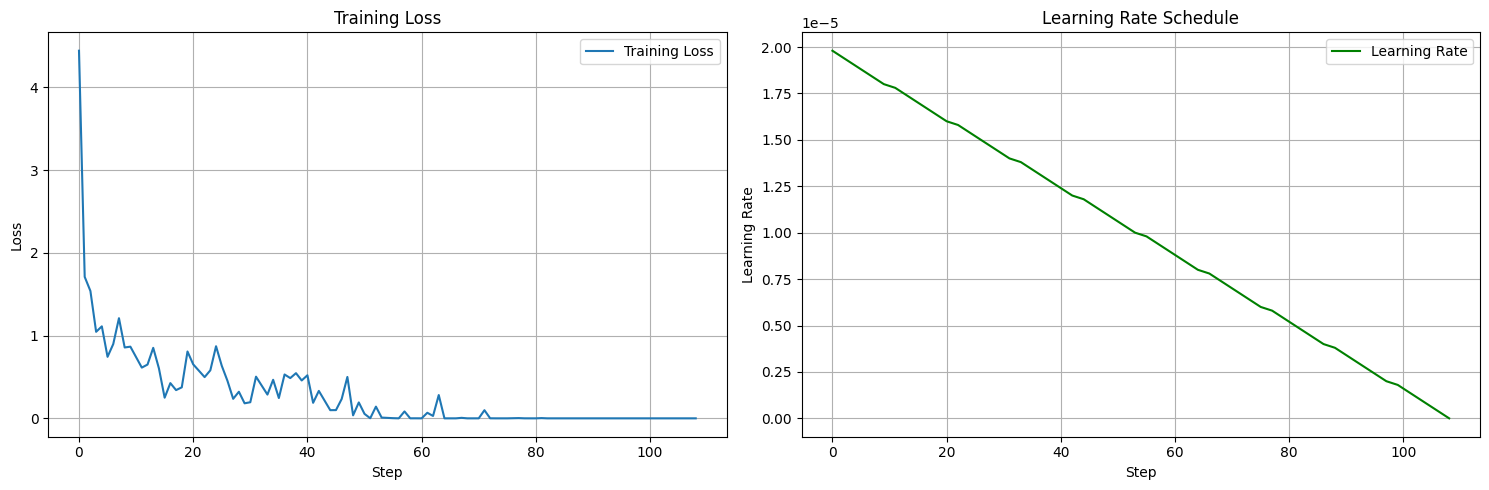

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=1000, training_loss=0.3047633919078933, metrics={'train_runtime': 4933.2741, 'train_samples_per_second': 1.622, 'train_steps_per_second': 0.203, 'total_flos': 8795770060800000.0, 'train_loss': 0.3047633919078933, 'epoch': 8.0})

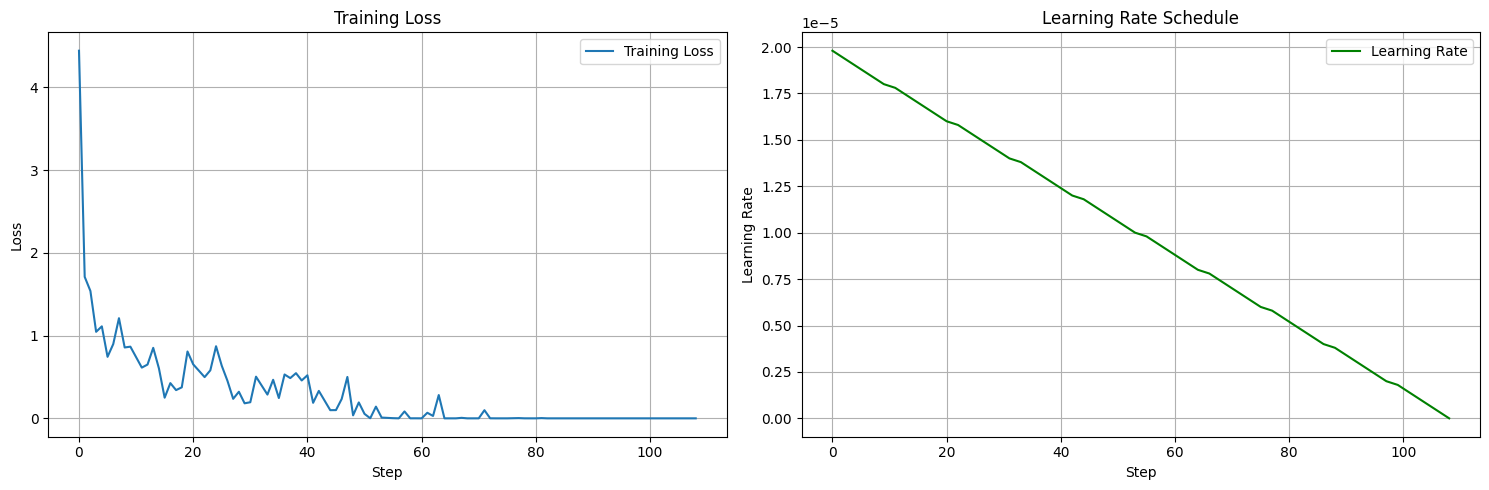

In [7]:
from transformers import TrainingArguments, Trainer, TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import display, update_display, HTML

class ProgressVisualizationCallback(TrainerCallback):
    def __init__(self):
        self.training_logs = []
        self.output_id = 'progress_viz'
        self.fig = None
    
    def on_train_begin(self, args, state, control, **kwargs):
        self.training_logs = []
        # Don't print anything here to avoid interfering with the default progress display
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            self.training_logs.append(logs)
            # Plot every 10 logs to avoid slowing down training
            if len(self.training_logs) % 10 == 0:
                self.visualize_progress(state)
    
    def visualize_progress(self, state):
        # Extract metrics
        steps = [log.get('step', i) for i, log in enumerate(self.training_logs) if 'loss' in log]
        loss = [log['loss'] for log in self.training_logs if 'loss' in log]
        lr = [log['learning_rate'] for log in self.training_logs if 'learning_rate' in log]
        
        # Create plot
        if self.fig is None:
            self.fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            display(self.fig, display_id=self.output_id)
        else:
            # Clear previous plot data
            for ax in self.fig.axes:
                ax.clear()
            ax1, ax2 = self.fig.axes
        
        # Loss plot
        ax1.plot(steps, loss, label='Training Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Learning rate plot
        ax2.plot(steps, lr, label='Learning Rate', color='green')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Learning Rate')
        ax2.set_title('Learning Rate Schedule')
        ax2.legend()
        ax2.grid(True)
        
        self.fig.tight_layout()
        update_display(self.fig, display_id=self.output_id)
        
        # Don't print status here to avoid interfering with the default progress display

# Setup training with proper logging
training_args = TrainingArguments(
    output_dir="test_trainer",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="steps",
    eval_steps=100,    # Evaluate every 100 steps
    save_strategy="steps",
    save_steps=500,    # Save model every 100 steps
    save_only_model=True,  # Only save model weights, not optimizer state
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=1000,    # Set a specific number of steps
    report_to="none",  # Disable wandb/tensorboard to avoid conflicts
    learning_rate=2e-5,
    weight_decay=0.01,
)

# Create the trainer with our callback
progress_callback = ProgressVisualizationCallback()
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[progress_callback],  # Add the callback here
)

# Start training
print("Starting training...")
trainer.train()

In [8]:
# Save in Hugging Face format
output_dir = "sentiment-llama-3.2"
print(f"Saving model to {output_dir}...")

# 1. Save the model in Hugging Face format
trainer.save_model(output_dir)  # This saves tokenizer, config, and model files

# 2. Optional: Save with a specific model name for better organization
from huggingface_hub import HfApi

# To save to your local directory with a better structure
model_name = "llama-3.2-sentiment-classifier"
local_dir = f"{model_name}-{trainer.state.global_step}"
trainer.save_model(local_dir)
print(f"✅ Model saved to {output_dir}")

# Optional: Push to Hugging Face Hub if you want to share
# Uncomment if you want to upload to HuggingFace Hub
# api = HfApi()
# api.upload_folder(
#     folder_path=local_dir,
#     repo_id=f"YOUR_USERNAME/{model_name}",
#     repo_type="model"
# )
# print(f"✅ Model pushed to HuggingFace Hub: YOUR_USERNAME/{model_name}")

# 3. Convert to Ollama format
print("Converting to Ollama format...")

# Create Modelfile for Ollama
ollama_dir = f"ollama-{model_name}-{trainer.state.global_step}"
import os
os.makedirs(ollama_dir, exist_ok=True)

# Write Modelfile
with open(f"{ollama_dir}/Modelfile", "w") as f:
    f.write(f"""FROM llama3.2
PARAMETER temperature 0.7
PARAMETER top_p 0.9
PARAMETER stop ["\n", "Human:", "Assistant:"]
SYSTEM You are a sentiment analysis assistant specialized in analyzing tweets. Classify sentiment as positive, negative, or neutral.

# Pull the model weights
ADAPTER file=pytorch_model.bin

LICENSE Apache 2.0
""")

# Copy necessary files from the HF format to Ollama format
import shutil
shutil.copy(f"{local_dir}/pytorch_model.bin", f"{ollama_dir}/pytorch_model.bin")
shutil.copy(f"{local_dir}/config.json", f"{ollama_dir}/config.json")

print(f"✅ Ollama files created in {ollama_dir}")
print("To use with Ollama, run:")
print(f"ollama create {model_name} -f {ollama_dir}/Modelfile")
print(f"ollama run {model_name}")


Saving model to sentiment-llama-3.2...
✅ Model saved to sentiment-llama-3.2
Converting to Ollama format...


FileNotFoundError: [Errno 2] No such file or directory: 'llama-3.2-sentiment-classifier-1000/pytorch_model.bin'

In [ ]:
# 4. Test the saved model using Hugging Face
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the saved model and tokenizer
loaded_model = AutoModelForCausalLM.from_pretrained(local_dir)
loaded_tokenizer = AutoTokenizer.from_pretrained(local_dir)

# Create a helper function to generate sentiment analysis with your model
def analyze_sentiment(tweet, max_length=50):
    prompt = f"Human: Analyze the sentiment of this tweet: '{tweet}'\n\nAssistant:"
    inputs = loaded_tokenizer(prompt, return_tensors="pt")
    
    # Generate response
    output = loaded_model.generate(
        inputs["input_ids"], 
        max_new_tokens=max_length,
        temperature=0.7,
        pad_token_id=loaded_tokenizer.eos_token_id
    )
    
    # Decode the response
    response = loaded_tokenizer.decode(output[0], skip_special_tokens=True)
    # Extract just the Assistant's response
    return response.split("Assistant:")[-1].strip()

# Test with a few examples
test_tweets = [
    "I love this product so much, best purchase ever!",
    "This is the worst customer service I've experienced, totally disappointed.",
    "The weather is cloudy today with a chance of rain."
]

print("\n--- Testing saved model ---")
for tweet in test_tweets:
    sentiment = analyze_sentiment(tweet)
    print(f"Tweet: {tweet}")
    print(f"Sentiment: {sentiment}")
    print("-" * 50)

# Test

In [9]:
import evaluate

trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 4.589754104614258,
 'eval_accuracy': 0.718,
 'eval_runtime': 164.1638,
 'eval_samples_per_second': 6.091,
 'eval_steps_per_second': 3.046,
 'epoch': 8.0}

=== Model Comparison: Fine-tuned vs Base ===

Evaluating fine-tuned model...


Evaluating Fine-tuned Model:   0%|          | 0/1000 [00:00<?, ?it/s]


=== Fine-tuned Model Evaluation Results ===
Accuracy: 0.7180

Classification Report:
  Negative: Precision=0.7323, Recall=0.6596, F1=0.6940
  Neutral: Precision=0.6689, Recall=0.7439, F1=0.7044
  Positive: Precision=0.7828, Recall=0.7370, F1=0.7592


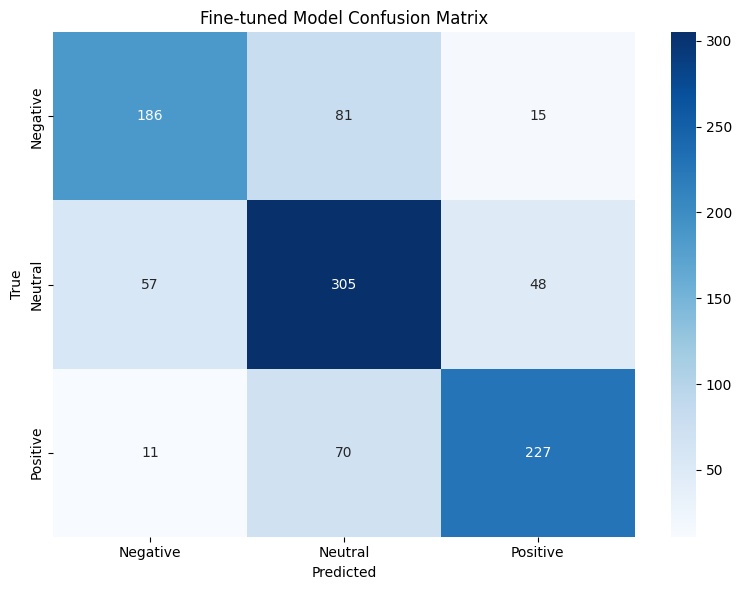


Evaluating base model...


Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Base Model:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Base Model Evaluation Results ===
Accuracy: 0.3080

Classification Report:
  Negative: Precision=0.0000, Recall=0.0000, F1=0.0000
  Neutral: Precision=0.0000, Recall=0.0000, F1=0.0000
  Positive: Precision=0.3083, Recall=1.0000, F1=0.4713


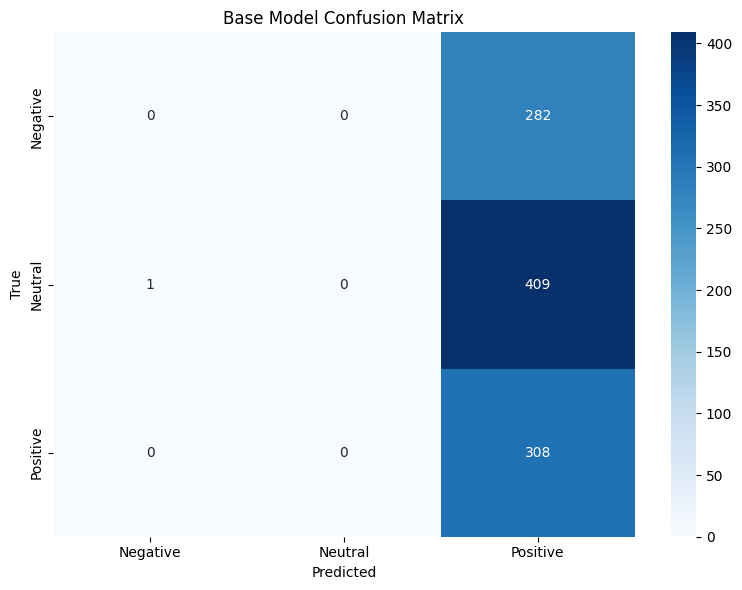

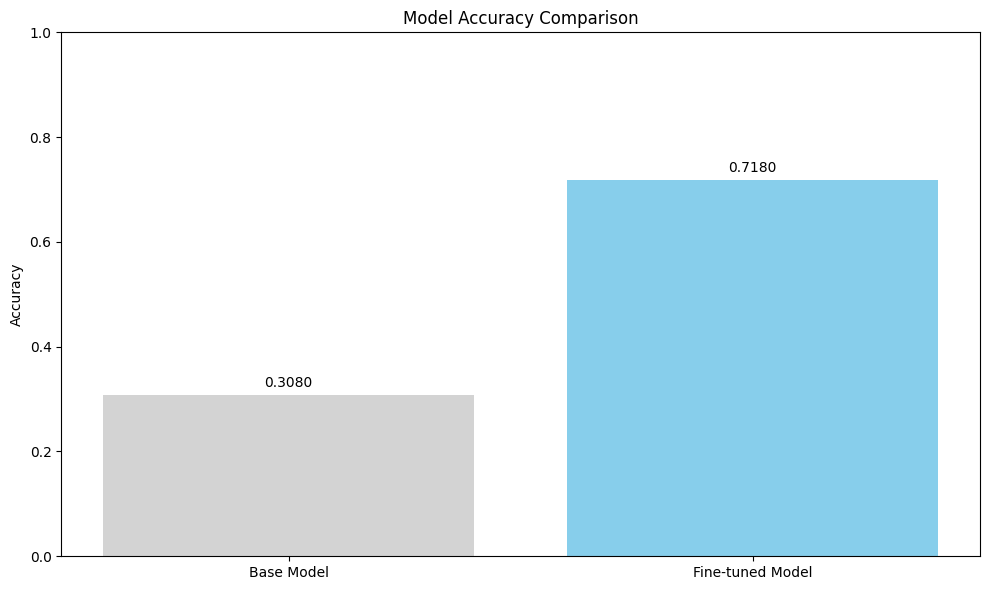


🔍 Performance Improvement: 41.00% absolute increase in accuracy

=== Example Predictions Comparison ===
Tweet:  so did you watch?  I`d forgottenmost of it, enjoyed re-seeing it, but paying for it today, my face doesnt bounce back anymore
True label: Positive
Base model prediction: Positive
Fine-tuned model prediction: Neutral
----------------------------------------------------------------------
Tweet: Im so angry right now .. today im not doind nothing and all my classmates yes  ,i think i will stay with my friend Mr.Computer .. hope not
True label: Negative
Base model prediction: Negative
Fine-tuned model prediction: Negative
----------------------------------------------------------------------
Tweet:  Sorry - I have failed to grasp your meaning
True label: Negative
Base model prediction: Negative
Fine-tuned model prediction: Negative
----------------------------------------------------------------------
Tweet:  It takes a big man to type a sad tweet like that!
True label: Negative

In [12]:
# Add model comparison functionality
import torch
# 1. Function to evaluate a model on the validation dataset
def evaluate_model(model, tokenizer, eval_dataset, name="Model"):
    """Evaluate a model on the validation dataset and return metrics"""
    from tqdm.notebook import tqdm
    import torch
    import numpy as np
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Process validation data in batches
    batch_size = 1  # adjust based on your GPU memory
    
    for i in tqdm(range(0, len(eval_dataset), batch_size), desc=f"Evaluating {name}"):
        batch = eval_dataset[i:i+batch_size]
        inputs = {k: torch.tensor(v).to(device) for k, v in batch.items() 
                 if k in ['input_ids', 'attention_mask']}
        labels = torch.tensor(batch['label']).to(device) if 'label' in batch else None
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        
        all_preds.extend(predictions)
        if labels is not None:
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
    
    # Print results
    print(f"\n=== {name} Evaluation Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    for label, metrics in report.items():
        if label in ["Negative", "Neutral", "Positive"]:
            print(f"  {label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Neutral", "Positive"],
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": cm,
        "predictions": all_preds,
        "labels": all_labels
    }

# 2. Compare fine-tuned model with base model
print("=== Model Comparison: Fine-tuned vs Base ===")

# First, evaluate the fine-tuned model that was just trained
print("\nEvaluating fine-tuned model...")
finetuned_metrics = evaluate_model(
    model=trainer.model,  # Use the trained model from the trainer
    tokenizer=tokenizer,
    eval_dataset=small_eval_dataset,
    name="Fine-tuned Model"
)

# Now, load a fresh instance of the base model and evaluate it
print("\nEvaluating base model...")
from transformers import AutoModelForSequenceClassification

base_model_fresh = AutoModelForSequenceClassification.from_pretrained(
    HF_MODEL_NAME, 
    num_labels=3
)

base_metrics = evaluate_model(
    model=base_model_fresh,
    tokenizer=tokenizer,
    eval_dataset=small_eval_dataset,
    name="Base Model"
)

# 3. Visualize the comparison
# Plot accuracy comparison
labels = ['Base Model', 'Fine-tuned Model']
accuracies = [base_metrics['accuracy'], finetuned_metrics['accuracy']]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=['lightgray', 'skyblue'])
plt.ylim(0, 1.0)  # Accuracy is between 0 and 1
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate improvement
improvement = (finetuned_metrics['accuracy'] - base_metrics['accuracy']) * 100
print(f"\n🔍 Performance Improvement: {improvement:.2f}% absolute increase in accuracy")

# 4. Example predictions comparison
print("\n=== Example Predictions Comparison ===")
# Sample 5 random examples from the validation set
import random
sample_indices = random.sample(range(len(small_eval_dataset)), 5)

for idx in sample_indices:
    example = small_eval_dataset[idx]
    text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
    true_label = example['label']
    
    # Get predictions from both models
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Base model prediction
    with torch.no_grad():
        base_outputs = base_model_fresh(**{k: v.to(base_model_fresh.device) for k, v in inputs.items()})
        base_pred = torch.argmax(base_outputs.logits, dim=-1).item()
    
    # Fine-tuned model prediction
    with torch.no_grad():
        ft_outputs = trainer.model(**{k: v.to(trainer.model.device) for k, v in inputs.items()})
        ft_pred = torch.argmax(ft_outputs.logits, dim=-1).item()
    
    # Map numerical labels to text
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    
    print(f"Tweet: {text}")
    print(f"True label: {label_map[true_label]}")
    print(f"Base model prediction: {label_map[base_pred]}")
    print(f"Fine-tuned model prediction: {label_map[ft_pred]}")
    print("-" * 70)